In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('data/churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df = df[df['Geography']=='Germany']
df.shape

(2509, 14)

In [4]:
df = df.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [6]:
df.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df['BalanceSalaryRatio'] = df['Balance']/df['EstimatedSalary']
df['TenureByAge'] = df['Tenure']/df['Age']
df['CreditScoreGivenAge'] = df['CreditScore']/df['Age']

In [8]:
df['Gender'] = df['Gender'].apply(lambda value: 1 if value == 'Male' else 0)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [9]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [10]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=0)

In [13]:
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag')
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print(f'Train f1 score: {round(metrics.f1_score(y_train, y_train_pred), 2)}')
print(f'Test f1 score: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

Train f1 score: 0.49
Test f1 score: 0.46


In [14]:
poly = preprocessing.PolynomialFeatures(include_bias=False, degree=3)
poly.fit(X_train)

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_poly.shape[1]

454

In [15]:
log_reg2 = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg2.fit(X_train_poly, y_train)

y_train_pred = log_reg2.predict(X_train_poly)
y_test_pred = log_reg2.predict(X_test_poly)

print(f'Train f1 score: {round(metrics.f1_score(y_train, y_train_pred), 2)}')
print(f'Test f1 score: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

Train f1 score: 0.65
Test f1 score: 0.63


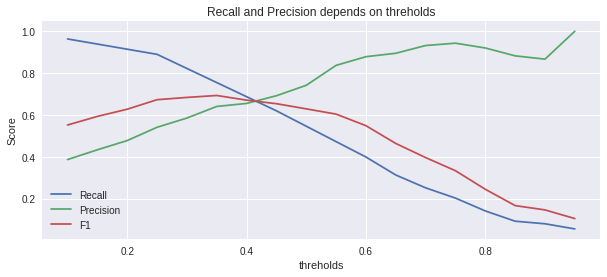

In [18]:
y_test_proba_pred = log_reg2.predict_proba(X_test_poly)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)

recall_scores = []
precision_scores = []
f1_scores = []

thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))
    
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1')

ax.set_title('Recall and Precision depends on threholds')
ax.set_xlabel('threholds')
ax.set_ylabel('Score')
ax.legend()

In [19]:
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > 0.35 else 0)

print(metrics.f1_score(y_test, y_test_pred_opt))

0.6929577464788731
